# Imports needed for this project

In [1]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time

# for plotting
import matplotlib.pyplot as plt

import pandas as pd

# Create driver object

In [2]:
driver = webdriver.Chrome(executable_path = 'C:/Users/mehak/Downloads/chromedriver')
driver

<selenium.webdriver.chrome.webdriver.WebDriver (session="fe6dc85ea85f8a7302c4fd56e5006346")>

## Login to your instagram handle

In [33]:
username = 'SAMPLE USERNAME'
password = 'SAMPLE PASSWORD'

In [7]:
def login_instagram(username, password):
    driver.get('https://www.instagram.com/accounts/login/?hl=en') #open login page of instagram

    wait = WebDriverWait(driver,20) # 20 is the upper limit
    ''' 
        Wait until page is loaded otherwise, exception occured
    '''
    name = wait.until(EC.presence_of_element_located( (By.NAME, 'username') ))
    name.send_keys(username) #see usename in top

    pass_word = driver.find_element_by_name('password')
    pass_word.send_keys(password)

    # Login 
    driver.find_element_by_class_name('sqdOP.L3NKy.y3zKF').click()

    '''
        Both login using facebook btn and not now button has same class. But login using facebook is on previous page , so 
        we need to wait for some time till next page is not loaded. We can't use explicit waiting bcz then it grabs login using 
        facebook button
    '''
    time.sleep(5) # 5 seconds wait
    try:
        # Don't save information for now. Sometimes ask and sometimes not. So put it in try block
        not_now = wait.until(EC.presence_of_element_located( (By.CLASS_NAME, 'sqdOP.yWX7d.y3zKF') ))
        not_now.click()     
    except:
        # It maeans save info popup don't come. Some other popup come
        driver.get('https://instagram.com')

    # Turn on notification or not
    try:
        not_now_turn = wait.until(EC.presence_of_element_located( (By.CLASS_NAME, 'aOOlW.HoLwm') ))
        not_now_turn.click()
    except:
        driver.get('https://instagram.com')
    

# calling function
login_instagram(username, password) # username and passwrd defined above in file

## Que 1. Now your friend has followed a lot of different food bloggers, he needs to analyse the habits of these bloggers.
### From the list of instagram handles you obtained when you searched ‘food’ in previous project. Open the first 10 handles and find the top 5 which have the highest number of followers

#### First we get list of insta handles which we get by searching food as we did in previous project

In [8]:
# This function return a list containing 1st 10 handles shown after searching keyword(except hashtags)
def search_and_return(keyword): 
    search_box = driver.find_element_by_xpath('//input[contains(@class,"XTCLo")]')
    search_box.clear() # So that if some text is present already, remove that
    search_box.send_keys(keyword)

    # List of all handles appeared afer searching food
    # wait until list appeared
    wait = WebDriverWait(driver,20) #Imports done previously. no need to do again

    food_list = wait.until(EC.presence_of_all_elements_located( (By.CLASS_NAME,'Ap253') ))
    insta_handles = [] # list of all insta handles
    for item in food_list:
        item_str = item.get_attribute('innerHTML').strip()
        if item_str[0]=='#':
            pass # Bcz we don't have to print hashtags
        else:
            insta_handles.append(item_str)
    return insta_handles[:10]

In [9]:
'''
    Now we open 1st 10 insta handles and and find their followers
    This function returns tuple of lists. one list shows handle name and other list shows number of followers 
'''
def open_and_find_top_5(keyword):
    base_url = 'https://www.instagram.com/'
    
    # Get 1st 10 handles list
    insta_handles = search_and_return(keyword)
    
    insta_followers = [] # List of tuples which stores number of followers particular handle have
    wait = WebDriverWait(driver,20) #Imports done previously. no need to do again
    for i in range(10):
        driver.get(base_url+insta_handles[i]) # open insta handle
        num_followers = wait.until(EC.presence_of_element_located( (By.XPATH, '//ul[@class="k9GMp "]/li[2]/a/span') )).get_attribute('title')

        #convert num_followers into int
        num_followers = num_followers.replace(",","")
        if num_followers == '':
            num_followers = 0
        else:
            num_followers = int(num_followers)
        insta_followers.append( (insta_handles[i], num_followers))

    # Sort according to number of followers
    insta_followers.sort(key = lambda x: x[1]) # in ascending order
    insta_followers = insta_followers[::-1] # in descending order

    # Top 5 having highest number of followers are
    top_5_followers_handle_name = []
    top_5_followers = []
    for i in range(5):
        top_5_followers_handle_name.append(insta_followers[i][0])
        top_5_followers.append(insta_followers[i][1])
        
    # return tuple of lists of handle names and their followers
    return (top_5_followers_handle_name, top_5_followers)


In [10]:
# Get top 5 handles and print
top_5_followers_handle_name , top_5_followers = open_and_find_top_5('food')

for i in range(5):
    print(top_5_followers_handle_name[i]," - ",top_5_followers[i], "followers")

buzzfeedfood  -  3735515 followers
foodgod  -  3602154 followers
foodinsider  -  2174868 followers
dilsefoodie  -  502037 followers
foodtalkindia  -  297368 followers


### Now Find the number of posts these handles have done in the previous 3 days.

In [18]:
# From above we have list of top 5 handles which have most number of followers in list top_5_followers_handle_name
def prev_3_day_posts(handle_list):
    num_posts = [] # list which stores number of previous 3 days posts above 5 handles has
    base_url = 'https://www.instagram.com/'
    for handle in handle_list:
        driver.get(base_url+handle) # open insta handle

        time.sleep(3) # wait for page to load
        posts_handle = driver.find_elements_by_xpath('//div[@class = "_9AhH0"]') # all posts on page
        count_post_handle = 0 # number of posts of previous 3 days for current handle
        wait = WebDriverWait(driver,20)
        for j in range(len(posts_handle)):
            driver.execute_script('arguments[0].click()',posts_handle[j]) # selenium click may raise exceptions but javascript click works fine
            post_time_tag = wait.until(EC.presence_of_element_located( (By.CLASS_NAME, '_1o9PC.Nzb55') ))
            post_time = post_time_tag.get_attribute('innerHTML').strip().split()
            if post_time[1].lower().startswith('day'):
                if int(post_time[0]) <=3 :
                    count_post_handle+=1
            elif post_time[1].lower().startswith('hour'): # use starts with bcz some times it is hour but sometimes it is hours 
                count_post_handle+=1
            else:
                break # bcz now after this no post have been posted within 3 previous days

        num_posts.append(count_post_handle)
        
    return num_posts


# call function
num_posts = prev_3_day_posts(top_5_followers_handle_name)
# Print Insta handles with their number of posts of previous days    
for i in range(5):
    print(top_5_followers_handle_name[i], " --> ", num_posts[i])

buzzfeedfood  -->  0
foodgod  -->  0
foodinsider  -->  3
dilsefoodie  -->  3
foodtalkindia  -->  5


### Depict this information using a suitable graph.

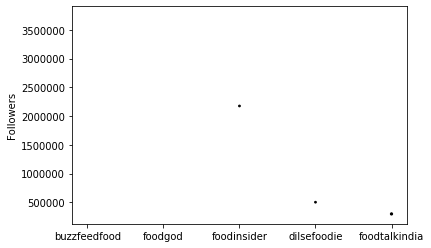

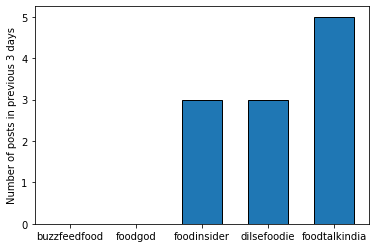

In [19]:
# all imports at top of file

plt.scatter(top_5_followers_handle_name, top_5_followers, s=num_posts, c='black')
plt.ylabel("Followers")
plt.show()

plt.bar(top_5_followers_handle_name,num_posts, width=0.6, edgecolor='black')
plt.ylabel("Number of posts in previous 3 days")
plt.show()

## Que 2. Your friend also needs a list of hashtags that he should use in his posts.
### Open the 5 handles you obtained in the last question, and scrape the content of the first 10 posts of each handle.

In [11]:
# From above we have list of 5
# top_5_followers_handle_name # list which contain names of 5 handles
def open_and_scrape(handle_list):
    post_contents = [] # which contains list of contents of 1st 10 posts of each 5 handles
    base_url = 'https://www.instagram.com/'
    for i in range(5):
        driver.get(base_url+handle_list[i]) # open insta handle
        time.sleep(2) # wait for page to load
        posts_i = driver.find_elements_by_xpath('//div[@class = "_9AhH0"]') # all posts on page

        # we only need to scrape the contents of 1st 10 posts
        post_contents_i = [] # list which contains contents of 10 posts of specific handle
        wait = WebDriverWait(driver,20)
        for j in range(10):
            driver.execute_script('arguments[0].click()',posts_i[j]) # selenium click may raise exceptions but javascript click works fine
            #time.sleep(2) # to load contents
            ele = wait.until(EC.presence_of_element_located( (By.CLASS_NAME,'PdwC2.fXiEu.s2MYR') ))
            data = BeautifulSoup(str(ele.get_attribute('outerHTML')),'lxml')
            content = data.get_text()
            post_contents_i.append(content)
      
            close_post_btn = driver.find_element_by_xpath('//div[contains(@class,"_2dDPU")]/div[3]/button')
            close_post_btn.click() #close current post
            time.sleep(1) #sleep for 1 seconds other directly clicking next post can raise exception

        post_contents.append(post_contents_i)
    
    return post_contents


# call function
post_contents = open_and_scrape(top_5_followers_handle_name)
# Lets Print post contents of 1st 2 posts of 5 handles
for i in range(5):
    print(post_contents[i][0]) # 1st post content 
    print(post_contents[i][1]) # 2nd post content

buzzfeedfoodVerified•Follow195,343 viewsFebruary 28
buzzfeedfoodVerified•Follow97,609 viewsbuzzfeedfoodVerifiedAre you ready to get bougie on a budget? You can get a Michelin star meal in Paris! 🇫🇷Follow 👉@bringme for more foodie adventures!18wsimplenutrition247🤩🤩2wReplyvegcomaPlease follow @vegcoma for vegetarian recipes!1wReplynycbakerydirectOmg!!1wReplygraussweetsensation❤️❤️1wReplyindiantravellerjiWow.👍1wReplyqibtiyah_naveedLuks amazing keep up the hard work❤️❤️🤤1wReplytravelers_in_tastingSuch fantastic desserts 😍1wReplysahoonsb😍😍😍4dReplymcribeyI’m allergic4dReplylilly_che8256😍 @carb_cuties2dReplysavourelishI’m an aspiring food blogger! Please check out my page10hReplychophappy😍😍😍😍😍7hReplyFebruary 27Post
foodgodVerified•FollowL&B Spumoni Gardens242,627 viewsfoodgodVerifiedBIG SURPRISE!!5davabracciaYou went to l&b and you didn't get a square slice?!5d3 likesReplyView replies (4)rossana_marieI can’t believe you were in my neighborhood again and I missed you5d8 likesReplyView replies 

### Prepare a list of all words used in all the scraped posts and calculate the frequency of each word.

In [12]:
def get_words_list(post_contents):
    words_list = []
    for i in range(5):
        for j in range(10): # bcz we scrape 10 posts of each 5 insta handles
            scraped_content = post_contents[i][j] # j post content of ith handle
            scraped_list = scraped_content.strip().split()
            for word in scraped_list:
                words_list.append(word)
                
    return words_list
            

words_list = get_words_list(post_contents)

# Store frequency of each word
word_freq = {}
for word in words_list:
    word_freq[word] = word_freq.get(word, 0) + 1
    
# Print words wit their frequency
for i in list(word_freq.items()):
    print(i)

('buzzfeedfoodVerified•Follow195,343', 1)
('viewsFebruary', 1)
('28', 1)
('buzzfeedfoodVerified•Follow97,609', 1)
('viewsbuzzfeedfoodVerifiedAre', 1)
('you', 55)
('ready', 1)
('to', 85)
('get', 9)
('bougie', 1)
('on', 20)
('a', 78)
('budget?', 1)
('You', 3)
('can', 13)
('Michelin', 1)
('star', 1)
('meal', 1)
('in', 72)
('Paris!', 1)
('🇫🇷Follow', 1)
('👉@bringme', 2)
('for', 58)
('more', 12)
('foodie', 6)
('adventures!18wsimplenutrition247🤩🤩2wReplyvegcomaPlease', 1)
('follow', 14)
('@vegcoma', 1)
('vegetarian', 1)
('recipes!1wReplynycbakerydirectOmg!!1wReplygraussweetsensation❤️❤️1wReplyindiantravellerjiWow.👍1wReplyqibtiyah_naveedLuks', 1)
('amazing', 6)
('keep', 1)
('up', 9)
('the', 142)
('hard', 5)
('work❤️❤️🤤1wReplytravelers_in_tastingSuch', 1)
('fantastic', 1)
('desserts', 1)
('😍1wReplysahoonsb😍😍😍4dReplymcribeyI’m', 1)
('allergic4dReplylilly_che8256😍', 1)
('@carb_cuties2dReplysavourelishI’m', 1)
('an', 6)
('aspiring', 1)
('food', 16)
('blogger!', 1)
('Please', 3)
('check', 4)
('out',

('tahini', 1)
('sauce4d5', 1)
('(1)sheepsheadbayguy993...no', 1)
('not4d4', 1)
('(1)tristenjbravoWhen', 1)
('having', 3)
('dish😍😍4d4', 1)
('(1)biggscltI', 1)
('LOVE', 1)
('guys.', 1)
('Extra', 1)
('extra', 3)
('red4d3', 1)
('likesReply4', 2)
('foodinsiderVerified•Follow3,066', 1)
('likesfoodinsiderVerifiedHow', 1)
('much', 8)
('sugar', 7)
('adding', 1)
('intake', 1)
('using', 2)
('condiments', 1)
('meals?', 1)
('20-ounce', 1)
('bottle', 4)
('Heinz', 2)
('tomato', 2)
('ketchup,', 1)
('example,', 1)
('contains', 1)
('two-thirds', 1)
('cup', 8)
('sugar.', 1)
('sauces', 1)
('dips', 1)
('stack', 1)
('against', 1)
('other.', 1)
('\u2063\u2063\u2063\u2063#sauce', 1)
('#condiment', 1)
('#ketchup', 1)
('#sugar\u2063\u2063\u2063\u2063(Credit:', 1)
('Hollis', 1)
('Johnson/', 1)
('Insider)4dalicaliser⠀⠀⠀⠀⠀⠀⠀.', 1)
('⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀✦⠀⠀⠀', 2)
('⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀', 2)
('⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀☄️', 2)
('⠀⠀⠀⠀⠀⠀.', 2)
('.⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀☀️', 2)
(',⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀.', 2)
('⠀🌕', 2)
('🌎⠀\u

('mny', 1)
('tyms3d4', 1)
('likesReplyelite_charanPaaji', 1)
('kyon', 1)
('bhukh', 1)
('lva', 1)
('rhe', 1)
('o3d3', 1)
('likesReplysinghsaurabh2298Karan', 1)
('bnaras', 1)
('ao', 1)
('kbhi🙏4d3', 1)
('likesReplysharmavishuOvercharged!', 1)
('cost', 1)
('Amritsar', 1)
('10₹3d3', 1)
('likesReplystreet_food_chandigarhKulche', 1)
('mei', 1)
('hoga3d2', 1)
('likesReplythinni_chennagiiri😍😍😍3d2', 1)
('likesReplymilan.junejaLike', 1)
('ittt3d2', 1)
('likesReplyap_food_cartWow', 2)
('😍😍😍3d2', 1)
('likesReplyan_nuttysoulWow😋3d2', 1)
('dilsefoodieVerified•Follow117,282', 1)
('viewsdilsefoodieVerifiedSeekh', 1)
('Kebab', 1)
('BiryaniVery', 1)
('Easy', 3)
('Make', 3)
('😬Try', 1)
('Recipe', 1)
('Tag', 1)
('Me', 1)
('Stories', 1)
("#dilsefoodie5diamhabilThat's", 1)
('Biryani...', 1)
("That's", 1)
('Gravy', 1)
('Rice', 1)
('together', 2)
('Dum...', 1)
('Biryani', 1)
('Whole', 1)
('spices,', 1)
('Masala,', 1)
('Layered', 1)
('rice', 2)
('Garnished', 1)
('Ghee,', 1)
('Saffron', 1)
('coriander', 1)
('lea

('quite', 1)
('okay', 1)
('😛2d1', 1)
('(2)2', 1)
('foodtalkindiaVerified•Follow4,579', 1)
('viewsfoodtalkindiaVerifiedIce', 1)
('cream...all', 1)
('day...every', 1)
('day.🍦🙌🏼', 1)
('#summervibes3dpickyplatesYaaas😍3d1', 1)
('likeReplythe_roz.ted_beans😍😍Cutie3d1', 1)
('likeReplyita_da_ki_masuHahah', 1)
('true😍2dReplyswati1588@ankiee31', 1)
('@shweta.pandey1593', 1)
('🙈3d3', 1)
('(1)sakshi.35@dikshita.7', 1)
('😍😍3d1', 1)
('(1)raashi05@sagar.chawdhary', 1)
('😬3d1', 1)
('likeReplykartik58_smasher@ankita.v.aggarwal3d1', 1)
('likeReplynehajattu@sid', 1)
('reminds', 1)
('us😜1dReply3', 1)
('foodtalkindiaVerified•Followthegrammarroomolivedelhi920', 1)
('likesfoodtalkindiaVerifiedNow', 1)
('delivery', 1)
('pick-up!', 1)
('eases', 1)
('little,', 1)
('gourmet', 1)
('delivery,', 1)
('bringing', 1)
('happiness', 1)
('back', 1)
('doorstep!To', 1)
('feed', 2)
('cravings,', 1)
('we’ve', 1)
('selection', 1)
('week', 1)
('must-order', 1)
('addresses.', 1)
('swipe', 1)
('left', 1)
('gorge', 1)
('home!@theg

### Create a csv file with two columns : the word and its frequency

In [13]:
columns = ['Word', 'Frequency']
word_freq_list = list(word_freq.items())
dataframe = pd.DataFrame(word_freq_list, columns = columns)

# Create csv
dataframe.to_csv('Word_Freq.csv')

dataframe.head(10)

,Word,Frequency
0,"buzzfeedfoodVerified•Follow195,343",1
1,viewsFebruary,1
2,28,1
3,"buzzfeedfoodVerified•Follow97,609",1
4,viewsbuzzfeedfoodVerifiedAre,1
5,you,55
6,ready,1
7,to,85
8,get,9
9,bougie,1


### Now, find the hashtags that were most popular among these bloggers

In [16]:
# from above words_list we search for hashtags
def get_hashtags(words_list): # Returns a list of hashtags
    hashtags = []
    for word in words_list:
        if word.strip()[0]=='#':
            hashtags.append(word.strip())
    return hashtags

def get_hashtag_freq(hashtags): # this function return dictionary of hashtags and their frequency
    hash_freq = {}
    for tag in hashtags:
        hash_freq[tag] = hash_freq.get(tag,0)+1
    return hash_freq


# calling functions
hashtags = get_hashtags(words_list)
hash_freq = get_hashtag_freq(hashtags)

# Now we find top 5 hashtags and their frequency
hash_freq_list = list(hash_freq.items())
hash_freq_list.sort(key=lambda x:x[1]) # in increasing order of frequency
hash_freq_list = hash_freq_list[::-1] # in decreasing order of frequency

# Print 
for i in hash_freq_list:
    print(i)

('#food', 4)
('#nyc', 2)
('#summervibes3dpickyplatesYaaas😍3d1', 1)
('#SaturdayMood1dnotacurryMust', 1)
('#sundayvibes21hkingoffoodtimesAmazing', 1)
('#Fishcurry1wabhishek_vaibhav_simonYaar', 1)
('#FoodFood', 1)
('#dilsefoodie', 1)
('#staysafe1w__imtushar__💕💕💕💕💕1w3', 1)
('#stayhome', 1)
('#firstonlinesocialmediaawards', 1)
('#worldsocialmediaday', 1)
('#NowMax', 1)
('#SocialMaxAwards2020', 1)
("#dilsefoodie5diamhabilThat's", 1)
('#dilsefoodie4daashoo_i_amToo', 1)
('#dilsefoodie2dachal_manchanda⠀⠀.', 1)
('#FoodInsider1wgraytathemGuys', 1)
('#tools', 1)
('#foodprep', 1)
('#FoodInsider1wrinnny_VerifiedHe', 1)
('#nycfoodies', 1)
('#Brooklyn', 1)
('#FoodInsider1waliciavehThe', 1)
('#Frenchfood', 1)
('#bread', 1)
('#baguette', 1)
('#FoodInsider6drinnny_VerifiedLoved', 1)
('#Chicagodogs', 1)
('#Chicago', 1)
('#nyc5drinnny_Verifiedstill', 1)
('#FoodInsider', 1)
('#pizzaBK', 1)
('#sugar\u2063\u2063\u2063\u2063(Credit:', 1)
('#ketchup', 1)
('#condiment', 1)
('#FoodInsider4dtaggert_tafDamn', 1)
('

### Plot a Pie Chart of the top 5 hashtags obtained and the number of times they were used by these bloggers in the scraped posts.

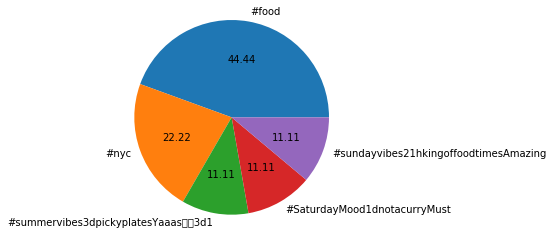

In [24]:
# first we get top 5 hashtags and their frequency using above hash_freq_list
top_5_hashtags = []
top_5_hashtags_freq = []
for i in range(5):
    top_5_hashtags.append(hash_freq_list[i][0])
    top_5_hashtags_freq.append(hash_freq_list[i][1])


# Now plot pie chart
plt.pie(top_5_hashtags_freq, labels=top_5_hashtags, autopct="%.2f")
plt.axis("equal")
plt.show()

## Que 3. You need to also calculate average followers : likes ratio for the obtained handles.

### Find out the likes of the top 10 posts of the 5 handles obtained earlier.

In [25]:
# From above we have list of 5
# top_5_followers_handle_name # list which contain names of 5 handles

def get_likes_of_top_10_posts(top_5_followers_handle_name):
    handle_likes = [] # which contains likes of top 10 posts of each 5 handles
    base_url = 'https://www.instagram.com/'
    for i in range(5):
        driver.get(base_url+top_5_followers_handle_name[i]) # open insta handle
        time.sleep(2) # wait for page to load
        posts_i = driver.find_elements_by_xpath('//div[@class = "_9AhH0"]') # all posts on page

        # we only need to scrape the contents of 1st 10 posts
        handle_likes_i = [] # list which contains likes of 10 posts of specific handle
        wait = WebDriverWait(driver,15)
        for j in range(10):
            driver.execute_script('arguments[0].click()',posts_i[j]) # selenium click may raise exceptions but javascript click works fine

            # Some posts has views mentioned . To get their likes click on view -> tooltip open which shows likes
            try:
                view = wait.until(EC.presence_of_element_located( (By.CLASS_NAME,'vcOH2') ))
                driver.execute_script("arguments[0].click()", view)
                time.sleep(2)
                likes = driver.find_element_by_xpath('//div[@class="vJRqr"]/span').get_attribute('innerHTML')
                driver.execute_script("arguments[0].click()", view) #click again to close likes tooltip
                likes = int(likes.replace(",","")) # convert into int
                handle_likes_i.append(likes)
            except: # some posts which have likes shown, in that case locating view as above raises exception
                likes = wait.until(EC.presence_of_element_located( (By.XPATH,'//div[@class="Nm9Fw"]/button/span') )).get_attribute('innerHTML')
                likes = int(likes.replace(",","")) # convert into int
                handle_likes_i.append(likes)


            close_post_btn = driver.find_element_by_xpath('//div[contains(@class,"_2dDPU")]/div[3]/button')
            close_post_btn.click() #close current post
            time.sleep(1) #sleep for 1 seconds other directly clicking next post can raise exception

        handle_likes.append(handle_likes_i)
    
    return handle_likes


# calling function
handle_likes = get_likes_of_top_10_posts(top_5_followers_handle_name)

# Lets Print likes of top 10 posts of 5 handles
for i in handle_likes:
    print(i)

[5633, 3828, 5244, 12619, 6104, 4030, 6927, 3042, 5265, 7983]
[6916, 10497, 22055, 36220, 5496, 21685, 40192, 7658, 32952, 14696]
[3143, 10447, 7899, 13596, 3067, 7267, 16429, 15538, 15459, 13622]
[1464, 10775, 8407, 12375, 10550, 8923, 5284, 9249, 12210, 8050]
[242, 825, 229, 2337, 380, 920, 324, 2948, 3431, 2502]


### Calculate the average likes for a handle.

In [26]:
def average_likes(handle_likes):
    average_handle_likes = []
    for i in handle_likes:
        avg = sum(i)/10
        average_handle_likes.append(avg)
    return average_handle_likes
    
    
# calling function
average_handle_likes = average_likes(handle_likes)
print(average_handle_likes)

[6067.5, 19836.7, 10646.7, 8728.7, 1413.8]


### Divide the average likes obtained from the number of followers of the handle to get the average followers:like ratio of each handle.

In [27]:
'''
    top_5_followers --> followers of top 5 handles
    average_handle_likes --> average likes of top 10 posts of top 5 handles
'''

def get_avg_followers_like_ratio(handle_followers, average_handle_likes):
    avg_followers_like_ratio = []
    for i in range(5):
        avg_followers_like_ratio.append( handle_followers[i]/average_handle_likes[i] )
    
    return avg_followers_like_ratio
    
# calling function
avg_followers_like_ratio = get_avg_followers_like_ratio(top_5_followers, average_handle_likes)
# print result
print(avg_followers_like_ratio)

[615.6596621343222, 181.5903854975878, 204.27625461410577, 57.51566670867368, 210.33243740274438]


### Create a bar graph to depict the above obtained information.

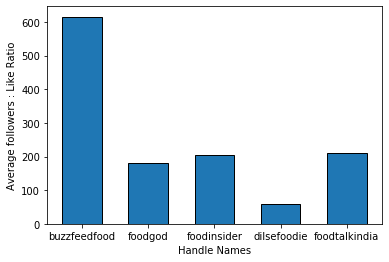

In [31]:
plt.bar(top_5_followers_handle_name, avg_followers_like_ratio, width=0.6, edgecolor='black')
plt.ylabel('Average followers : Like Ratio')
plt.xlabel('Handle Names')
plt.show()

In [32]:
driver.quit()